# Semantic Segmentation with Residual Attention U-net
In this notebook we will use the U-net architecture to predict which pixels in images of hippocampus sections belong to mitochondria. This type of problem set is termed semantic segmentation and the U-net (as introduced by Ronnenberger et al. (www.arxiv.org/abs/1505.04597)) is a useful convolutional neural network architecture to approach the problem of semantic segmentation. The U-net architecture is extended to include attention gates as described by Oktay et al. (https://arxiv.org/pdf/1804.03999.pdf). Additionally, residual units are incorporated similar to work by Zhang et al. (https://arxiv.org/pdf/1711.10684.pdf). The image data used in this notebook can be download from following website: www.epfl.ch/labs/cvlab/data/data-em/. We will first load the image data:

In [1]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
import random 
import warnings
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Concatenate, Add, Activation, Multiply
from itertools import product

tf.random.set_seed(2)
random.seed(2)

# Load image data and normalize
file_path_train = ".//training.tif"
file_path_train_mask = ".//training_groundtruth.tif"
file_path_test = ".//testing.tif"
file_path_test_mask = ".//testing_groundtruth.tif"

train = io.imread(file_path_train)
train_mask = io.imread(file_path_train_mask)
test = io.imread(file_path_test)
test_mask = io.imread(file_path_test_mask)

train = np.expand_dims(train / 255, 3)
train_mask = np.expand_dims(train_mask / 255, 3)
test = np.expand_dims(test / 255, 3)
test_mask = np.expand_dims(test_mask / 255, 3)

Let's quickly visualize one image and verify that the corresponding mask belongs to the same image:

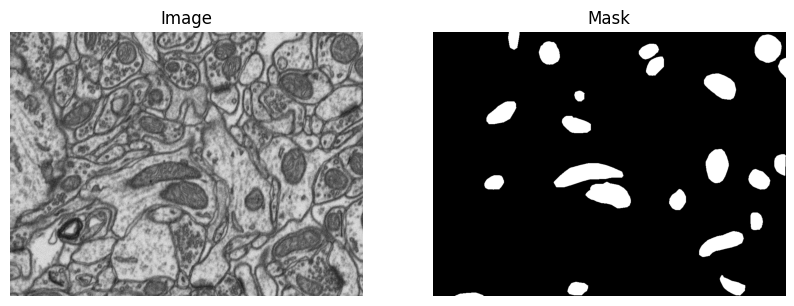

In [2]:
fig, ax = plt.subplots(1,2, figsize=(10, 8))
ax[0].imshow(train[0], cmap="gray")
ax[0].set_title("Image")
ax[1].imshow(train_mask[0], cmap="gray")
ax[1].set_title("Mask")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

The training data only contains 165 images. In addition to the small number of training images, these images represent consecutive slices taken from the hippocampus region of the brain. Therefore, some of the images are relatively similiar. To avoid overfitting, it is consequently advisable to augment the training images. We will do so by rotating, flipping, stretching, and zooming in. For our needs, the augmentation procedure has to be exactly the same for each image/mask pair. We will use the albumentations package (www.albumentations.ai) for this as it offers useful functionality for this scenario. We create 330 augmented training images by the code cell shown below:

In [3]:
repetitions = 1 # 1 means every training image is augmented once
train_augmented = np.zeros((train.shape[0] * (repetitions + 1), train.shape[1], train.shape[2], train.shape[3]))
train_augmented[0:train.shape[0]] = train
train_mask_augmented = np.zeros((train_mask.shape[0] * (repetitions + 1), 
                                 train_mask.shape[1], 
                                 train_mask.shape[2], 
                                 train_mask.shape[3]))
train_mask_augmented[0:train_mask.shape[0]] = train_mask

idxs = list(zip(range(train.shape[0], train_augmented.shape[0]), 
                   [k for k in range(0, train.shape[0]) for _ in range(repetitions)]))
for idx in idxs:
    transform = A.Compose([
        A.Rotate(30, p=0.7),
        A.HorizontalFlip(p=0.7),
        A.VerticalFlip(p=0.7),
        A.RandomCrop(width=int(train.shape[2] * random.uniform(0.9, 1)), 
                     height=int(train.shape[1] * random.uniform(0.9, 1))),
        A.Resize(train.shape[1], train.shape[2])])
    transformed = transform(image=train[idx[1]], mask=train_mask[idx[1]])
    train_augmented[idx[0]] = transformed["image"]
    train_mask_augmented[idx[0]] = transformed["mask"]

Let's quickly visualize that augmentation was succesful and that the masks fit to the augmented images:

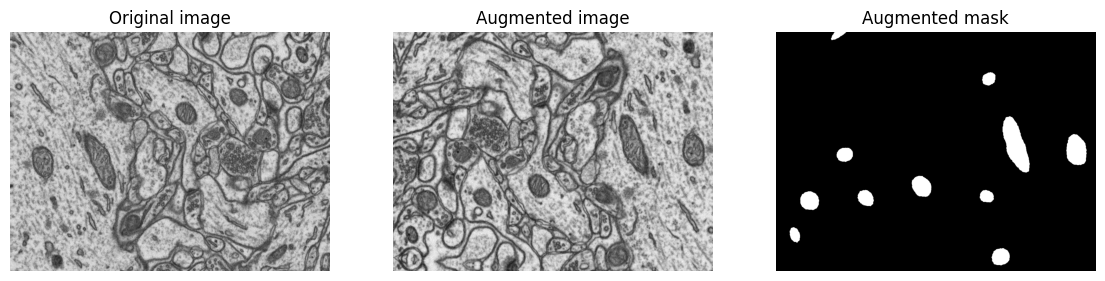

In [4]:
fig, ax = plt.subplots(1,3, figsize=(14, 8))
ax[0].imshow(train[-2], cmap="gray")
ax[0].set_title("Original image")
ax[1].imshow(train_augmented[-2], cmap="gray")
ax[1].set_title("Augmented image")
ax[2].imshow(train_mask_augmented[-2], cmap="gray")
ax[2].set_title("Augmented mask")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

Training segmentation tasks on large images can be very resource intensive. Therefore, the class PatchPredictReassemble implements functionality that allows for creation of smaller patches from larger images. It also implements functionality that allows prediction on these patches (if given a previously trained model) and then reassembles the predicted mask to the image shape of the original input image. The patching in this class has two modi. In modus="train" non-overlapping patches are created. In modus="train" overlapping patches are created and then reassembled in a way that reduces predictions originating from near the patch boundaries. The two modi are illustrated below:

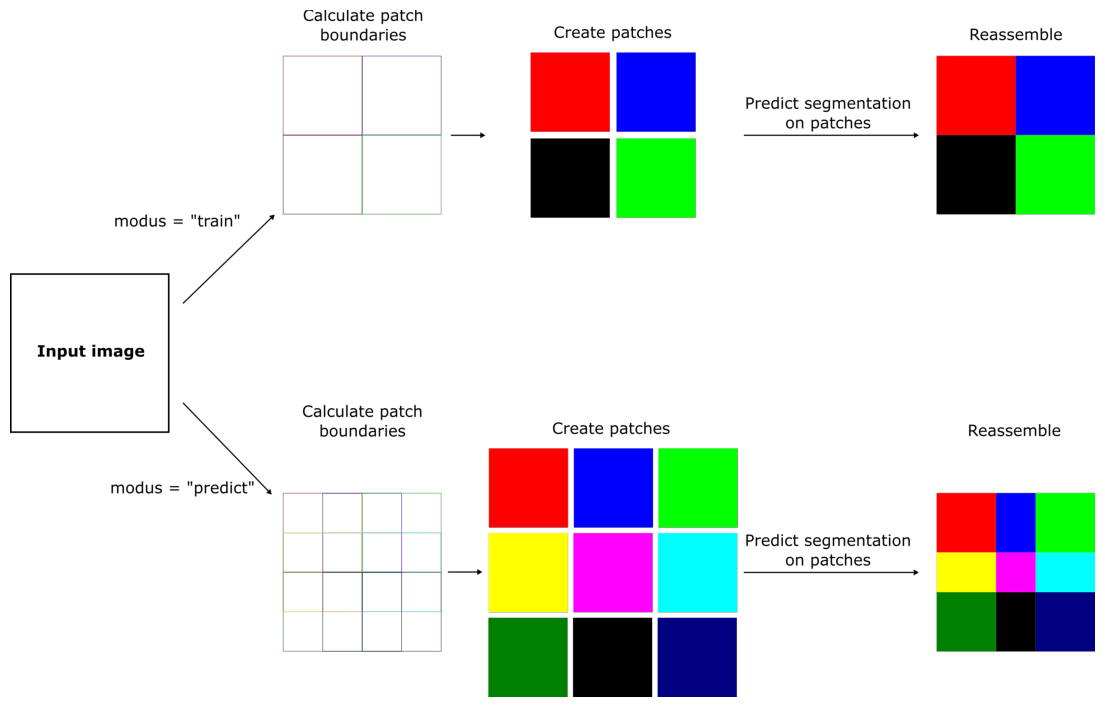

In [5]:
scheme = io.imread(".//patchpredictreassemble.png")
fig, ax = plt.subplots(figsize=(14, 10))
ax.imshow(scheme, cmap="hsv")
ax.set_axis_off()
plt.show()

In [6]:
class Patcher():
    """
    This class is concerned with slicing a larger image into smaller patches, predicting if pixels in those patches belong
    to the target class, and subsequently reassembling those predicted patch masks to masks that fit the original input 
    image shape.
        
    Overview of Methods
    -------
    create_patches
    predict_patches
    reassemble_patches
    """
        
    def create_patches(self, imgs, patch_size, train=True):
        """
        Creates smaller patches from larger images. Either non-overlapping patches or overlapping patches can be created. 
        
        Parameters
        ----------
        imgs: numpy.array
            Input image data with following shape: (number of images, image height in pixel, image width in pixel, number of 
            channels).
        patch_size: tuple
            Size of the patches that are to be returned. Format: (image height, image width).
        train: boolean
            If train, non-overlapping patches will be created. See above.
        
        Returns
        -------
        patched_imgs: numpy.array
            Patches created from the images.
        """
    
        self.increment_factor = 1 if train else 0.5
        self.train = train
        self.no_imgs = imgs.shape[0]
        self.img_width = imgs.shape[1]
        self.img_length = imgs.shape[2]
        self.patch_width = patch_size[0]
        self.patch_length = patch_size[1]
        
        self.y_increment = self.patch_width * self.increment_factor 
        self.x_increment = self.patch_length * self.increment_factor 
        self.no_patches_y = ((self.img_width - self.patch_width) / self.y_increment) + 1 
        self.no_patches_x = ((self.img_length - self.patch_length) / self.x_increment) + 1

        check_patch_size = [i.is_integer() for i in [self.no_patches_x, self.no_patches_y]]
        if all(check_patch_size):
            self.no_patches_x = int(self.no_patches_x)
            self.no_patches_y = int(self.no_patches_y)
            self.y_increment = int(self.y_increment)
            self.x_increment = int(self.x_increment)
        else:
            raise ValueError("""Please use a combination of patch size & slide factor that allows patching of the image 
                             without remainder.""")

        self.no_patched_imgs = self.no_imgs * self.no_patches_x * self.no_patches_y
        self.patched_imgs = np.zeros((self.no_patched_imgs, self.patch_width, self.patch_length, 1))
        
        for idx0, (idx1, idx2, idx3) in enumerate(product(range(self.no_imgs), 
                                                          range(self.no_patches_x), 
                                                          range(self.no_patches_y))):
            self.patched_imgs[idx0] = imgs[
                idx1,
                (idx3 * self.y_increment):(idx3 * self.y_increment + self.patch_width),
                (idx2 * self.x_increment):(idx2 * self.x_increment + self.patch_length), 
                :]
        return self.patched_imgs
        
    def predict_patches(self, model, cutoff=0.5):
        """
        Predicts if a pixel in a given patch belong to the target class and returns the corresponding predicted mask.
        
        Parameters
        ----------
        model: 
            A model that features a predict method that if feed with the patches stored in the "patched_images" attribute
            returns probabilities for each pixel that indicate if that pixel belongs to the target class.
        
        cutoff: float
            Predicted probabilities larger than the cutoff value are converted to 1, meaning the pixel is assigned to the 
            target class.
            Predicted probabilities lower than the cutoff value are converted to 0, meaning the pixel is not assigned to the
            target class.
        """
        
        self.model = model
        self.predictions = self.model.predict(self.patched_imgs)
        self.predictions = np.where(self.predictions > cutoff, 1, 0)    
    
    def reassemble_patches(self):
        """
        Reassembles the predicted masks from the predicted patches (="predictions" attribute) so that they fit the shape 
        of the original input image data.
        
        Returns
        -------
        imgs_reassembled: numpy.array
            Predicted masks for each of the original input images.
        """
            
        self.imgs_reassembled = np.zeros((self.no_imgs, self.img_width, self.img_length, 1))
        
        y_idx, x_idx = [0], [0]
        for y in range(self.no_patches_y):
            if ((y == 0) or (y == self.no_patches_y - 1)) and not self.train:
                y_idx.append(int(y_idx[-1] + self.y_increment * 1.5))
            else: 
                y_idx.append(int(y_idx[-1] + self.y_increment))
                
        for x in range(self.no_patches_x):
            if ((x == 0) or (x == self.no_patches_x - 1)) and not self.train:
                x_idx.append(int(x_idx[-1] + self.x_increment * 1.5))
            else: 
                x_idx.append(int(x_idx[-1] + self.x_increment))

        for idx0, (idx1, idx2, idx3) in enumerate(product(range(self.no_imgs), 
                                                          range(self.no_patches_x), 
                                                          range(self.no_patches_y))):
            self.imgs_reassembled[idx1, y_idx[idx3]:y_idx[idx3+1], x_idx[idx2]:x_idx[idx2+1], :] = \
             self.predictions[idx0, (y_idx[idx3] - idx3 * self.y_increment):(y_idx[idx3+1] - idx3 * self.y_increment),
                              (x_idx[idx2] - idx2 * self.x_increment):(x_idx[idx2+1] - idx2 * self.x_increment), :]
        return self.imgs_reassembled

The original images have a (768, 1024) px shape. We will create (256 x 256) px patches from the image data:

In [7]:
patch_size = (256, 256)

train_patches = Patcher().create_patches(train_augmented, patch_size, train=True)
train_mask_patches = Patcher().create_patches(train_mask_augmented, patch_size, train=True)
test_patches = Patcher().create_patches(test, patch_size, train=True)
test_mask_patches = Patcher().create_patches(test_mask, patch_size, train=True)

Let's visualize that creation of patches was succesful for both images and corresponding masks:

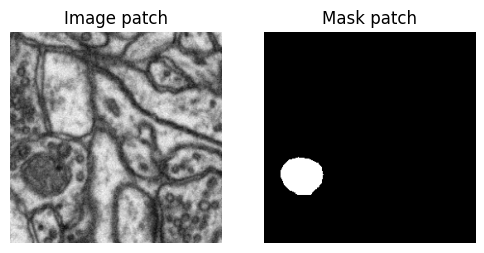

In [8]:
fig, ax = plt.subplots(1,2, figsize=(6, 4))
ax[0].imshow(train_patches[-2], cmap="gray")
ax[0].set_title("Image patch")
ax[1].imshow(train_mask_patches[-2], cmap="gray")
ax[1].set_title("Mask patch")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

Now, we will construct our attention U-net architecture:

In [9]:
def attention_res_u_net(input_shape, seed):
    inputs = Input(shape=input_shape)
    initializer = tf.keras.initializers.HeNormal(seed=seed)
    
    def residual_conv_block(x, filters, pooling):
        if pooling:
            x = MaxPooling2D((2, 2))(x)
        x = BatchNormalization()(x)  
        
        x1 = Activation("relu")(x)
        x1 = Conv2D(filters, (3, 3), strides=(1, 1), padding="same", kernel_initializer=initializer)(x)
        x1 = BatchNormalization()(x1)
        x1 = Activation("relu")(x1)
        x1 = Conv2D(filters, (3, 3), strides=(1, 1), padding="same", kernel_initializer=initializer)(x1)
        
        x2 = Activation("relu")(x)
        x2 = Conv2D(filters, (1, 1), strides=(1, 1), padding="same", kernel_initializer=initializer)(x2)
        
        x3 = Add()([x1, x2])
        return x3
    
    def attention_gate(g, x):
        """
        g: gating signal
        x: skip connection
        """
        no_of_sigmoid1_filters = x.shape[3]
        sigmoid1 = Activation("relu")(
            Add()([Conv2D(no_of_sigmoid1_filters, (1, 1), strides=(2, 2), padding="same", 
                          kernel_initializer=initializer)(x),
                   Conv2D(no_of_sigmoid1_filters, (1, 1), strides=(1, 1), padding="same", 
                          kernel_initializer=initializer)(g)
                  ])
        )   
        sigmoid1 = BatchNormalization()(sigmoid1)
        sigmoid2 = Conv2D(1, (1, 1), activation="sigmoid", padding="same", kernel_initializer=initializer)(sigmoid1)
        sigmoid2 = BatchNormalization()(sigmoid2)
        alpha = UpSampling2D(interpolation="bilinear")(sigmoid2)
        x_hat = Multiply()([x, alpha])
        x_hat = BatchNormalization()(x_hat)
        return x_hat
    
    def expansion_block(g, x, filters):
        e_b = UpSampling2D(interpolation="bilinear")(g)
        e_b = BatchNormalization()(e_b)
        a = attention_gate(g, x)
        e_a = residual_conv_block(Concatenate()([a, e_b]), filters=filters, pooling=False)
        return e_a  
    
    # Contraction
    c1 = residual_conv_block(x=inputs, filters=16, pooling=False)
    c2 = residual_conv_block(x=c1, filters=32, pooling=True)
    c3 = residual_conv_block(x=c2, filters=64, pooling=True)
    
    # Bottleneck
    c4 = residual_conv_block(x=c3, filters=128, pooling=True)
    
    # Expansion
    e3 = expansion_block(c4, c3, 64)
    e2 = expansion_block(e3, c2, 32)
    e1 = expansion_block(e2, c1, 16)
    
    # Final
    outputs = Conv2D(1, (3, 3), activation="sigmoid", padding="same", kernel_initializer=initializer)(e1)

    # Get the model
    model = Model(inputs=inputs, outputs=outputs)
    
#     tf.keras.utils.plot_model(model, to_file="attention_res_u-net.png", show_shapes=True)
#     model.summary()
    return model


unet2 = attention_res_u_net(input_shape=(256,256,1), seed=42)

Let's train the model and visualize the training progress:

In [10]:
def scheduler(epoch, lr): 
    return lr * 0.95


unet2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-4), loss="binary_crossentropy")
cb1 = callbacks.EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=10)               
cb2 = callbacks.LearningRateScheduler(scheduler)
cb3 = callbacks.ModelCheckpoint(".\\unet2", monitor="val_loss", save_best_only=True)

# Saving the model produces a CustomMaskWarning. The model can however be saved and loaded later on without problems
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    history = unet2.fit(train_patches, train_mask_patches, 
                        epochs=100, batch_size=32, validation_data=(test_patches, test_mask_patches),
                        shuffle=True, verbose=1, callbacks=[cb1, cb2, cb3])

Epoch 1/100
124/124 [==============================] - ETA: 0s - loss: 0.0983 INFO:tensorflow:Assets written to: .\unet2\assets


INFO:tensorflow:Assets written to: .\unet2\assets


124/124 [==============================] - 2037s 16s/step - loss: 0.0983 - val_loss: 0.2390 - lr: 3.8000e-04
Epoch 2/100
124/124 [==============================] - ETA: 0s - loss: 0.0365 INFO:tensorflow:Assets written to: .\unet2\assets


INFO:tensorflow:Assets written to: .\unet2\assets


124/124 [==============================] - 2023s 16s/step - loss: 0.0365 - val_loss: 0.2378 - lr: 3.6100e-04
Epoch 3/100
124/124 [==============================] - ETA: 0s - loss: 0.0287 INFO:tensorflow:Assets written to: .\unet2\assets


INFO:tensorflow:Assets written to: .\unet2\assets


124/124 [==============================] - 2026s 16s/step - loss: 0.0287 - val_loss: 0.1649 - lr: 3.4295e-04
Epoch 4/100
124/124 [==============================] - ETA: 0s - loss: 0.0256 INFO:tensorflow:Assets written to: .\unet2\assets


INFO:tensorflow:Assets written to: .\unet2\assets


124/124 [==============================] - 2019s 16s/step - loss: 0.0256 - val_loss: 0.0545 - lr: 3.2580e-04
Epoch 5/100
124/124 [==============================] - ETA: 0s - loss: 0.0229 INFO:tensorflow:Assets written to: .\unet2\assets


INFO:tensorflow:Assets written to: .\unet2\assets


124/124 [==============================] - 2021s 16s/step - loss: 0.0229 - val_loss: 0.0330 - lr: 3.0951e-04
Epoch 6/100
124/124 [==============================] - 2008s 16s/step - loss: 0.0209 - val_loss: 0.0362 - lr: 2.9404e-04
Epoch 7/100
124/124 [==============================] - 1996s 16s/step - loss: 0.0197 - val_loss: 0.0371 - lr: 2.7933e-04
Epoch 8/100
124/124 [==============================] - 1996s 16s/step - loss: 0.0190 - val_loss: 0.0354 - lr: 2.6537e-04
Epoch 9/100
124/124 [==============================] - 1996s 16s/step - loss: 0.0181 - val_loss: 0.0361 - lr: 2.5210e-04
Epoch 10/100
124/124 [==============================] - 1996s 16s/step - loss: 0.0173 - val_loss: 0.0359 - lr: 2.3949e-04
Epoch 11/100
124/124 [==============================] - 2015s 16s/step - loss: 0.0165 - val_loss: 0.0355 - lr: 2.2752e-04
Epoch 12/100
124/124 [==============================] - 2013s 16s/step - loss: 0.0158 - val_loss: 0.0359 - lr: 2.1614e-04
Epoch 13/100
124/124 [===================

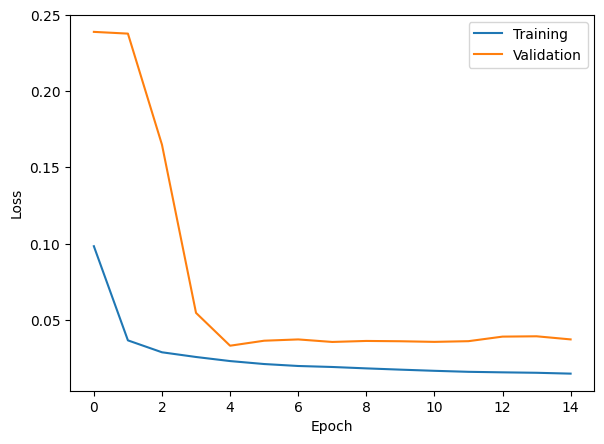

In [11]:
fig, ax = plt.subplots()
ax.plot(history.history["loss"], label="Training")
ax.plot(history.history["val_loss"], label="Validation")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.tight_layout(pad=2.0)
plt.show()

And are now able to load the trained model:

In [12]:
unet2 = tf.keras.models.load_model(".\\unet2", compile=False)

Now, let's predict on the test set images:

In [13]:
patcher = Patcher()
patcher.create_patches(test, patch_size, train=False)
patcher.predict_patches(unet2)
test_predictions = patcher.reassemble_patches()

181/181 [==============================] - 612s 3s/step


Let's visualize how good our prediction correspond to the actual mitochondria:

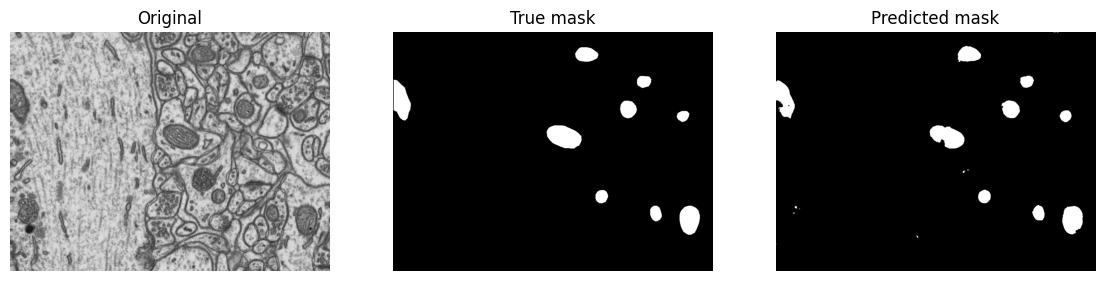

In [14]:
fig, ax = plt.subplots(1,3, figsize=(14, 8))
ax[0].imshow(test[-1], cmap="gray")
ax[0].set_title("Original")
ax[1].imshow(test_mask[-1], cmap="gray")
ax[1].set_title("True mask")
ax[2].imshow(test_predictions[-1], cmap="gray")
ax[2].set_title("Predicted mask")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

Finally, we calculate the mean intersection-over-union metric for all the test set predictions:

In [15]:
m1 = tf.keras.metrics.MeanIoU(num_classes=2)
m1.update_state(test_mask, test_predictions)
print(f"The mean intersection-over-union score for the test set is: {m1.result().numpy():.3f}")

The mean intersection-over-union score for the test set is: 0.871


In the above predicted mask, it becomes apparent that sometimes very tiny pixel agglomerations are predicted to be cell nuclei as well. They are way smaller than we can be expect from real nuclei, so we can remove these pixels:

In [16]:
def clean_masks(masks, min_area):
    """
    Cleans arrays of binary masks from agglomerations that contain only few directly adjacent members.
        
    Parameters
    ----------
    masks: np.array
        Array of binary masks of shape (no of masks, mask height, mask width, no of channels)
    min_area: int
        Minimum number of adjacent pixels that is need for each agglomeration in the mask to be retained during cleaning. 
    """
    masks = masks.astype("uint8")
    masks_clean = np.zeros_like(masks)
    for idx in range(masks.shape[0]):
        no_agglomerations, mask_labeled, stats, _ = cv2.connectedComponentsWithStats(masks[idx])
        areas = stats[1:, -1]
        for agg in range(no_agglomerations - 1):
            if areas[agg] > min_area:
                masks_clean[idx][mask_labeled == (agg + 1)] = 1
    return masks_clean
        

test_predictions_clean = clean_masks(test_predictions, 250)

Let's have look if this clean up was succesful:

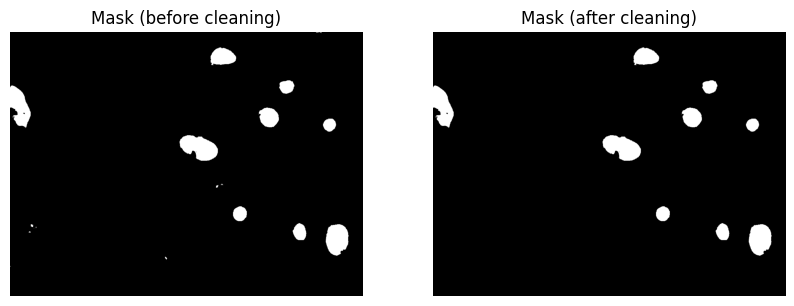

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(test_predictions[-1], cmap="gray")
ax[0].set_title("Mask (before cleaning)")
ax[1].imshow(test_predictions_clean[-1], cmap="gray")
ax[1].set_title("Mask (after cleaning)")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

The success of this clean up also manifests itself in a slightly increase interesection-over-union:

In [18]:
m2 = tf.keras.metrics.MeanIoU(num_classes=2)
m2.update_state(test_mask, test_predictions_clean)
print(f"The mean intersection-over-union score for the test set is: {m2.result().numpy():.3f}")

The mean intersection-over-union score for the test set is: 0.875
